# Trabajo Práctico 5 - Procesamiento de Imágenes
- Francisco Devaux
- Agustín Yornet

## Ejercicio 3
> Umbralización híbrida (combinación de Otsu + morfología). ¿Cómo mejorar la segmentación
de objetos con ruido o regiones conectadas? Práctica sugerida: Aplicar Otsu, luego refinar con
cv2.morphologyEx() (apertura o cierre).

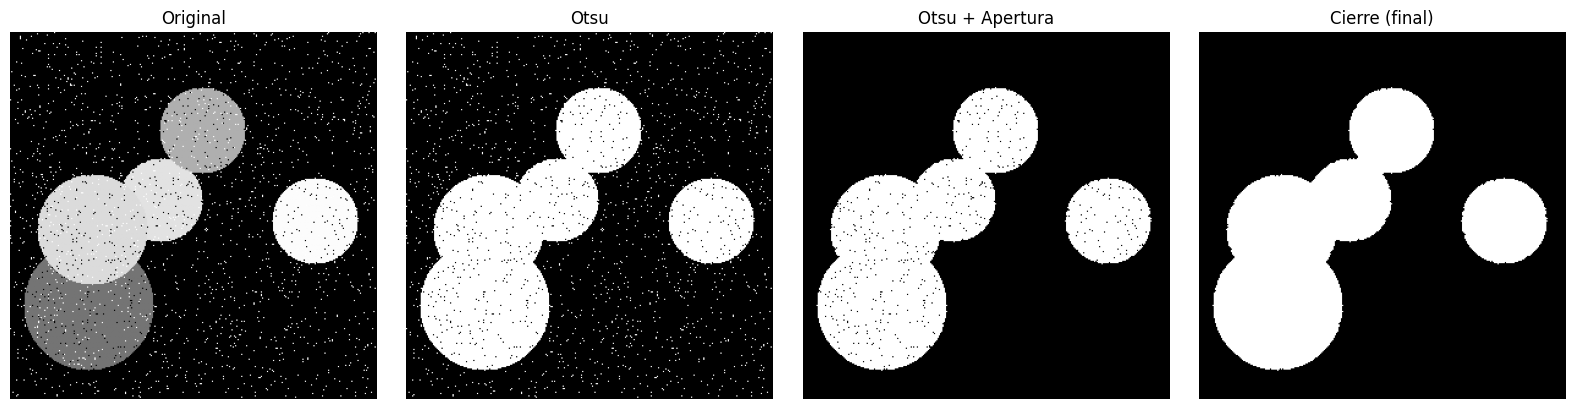

In [21]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./imagenes/img_grises2_ruido.png', cv2.IMREAD_GRAYSCALE)

_, otsu_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

apertura = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel)
cierre = cv2.morphologyEx(apertura, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(16, 4))

titles = ['Original', 'Otsu', 'Otsu + Apertura', 'Cierre (final)']
images = [img, otsu_thresh, apertura, cierre]

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

Se puede concluir que la combinación de operaciones fue altamente efectiva para lograr una segmentación limpia y precisa a partir de una imagen con alto nivel de ruido. El método de Otsu por sí solo logró una separación inicial de los círculos y el fondo, pero fue incapaz de manejar el ruido de tipo "sal y pimienta", dejando píxeles blancos dispersos en el fondo y agujeros negros dentro de los objetos. La posterior aplicación de una operación de apertura fue fundamental para eliminar exitosamente el ruido "sal" del fondo, mientras que el paso final de cierre complementó el proceso al rellenar los agujeros internos de los círculos. Por lo tanto, la estrategia completa demuestra ser una solución robusta que transforma la ruidosa imagen original en una máscara binaria clara y bien definida de los objetos de interés.

## Ejercicio 4

> Segmentación por detección de bordes. ¿Cómo se puede usar la información de bordes para segmentar una imagen? Práctica sugerida: Detectar bordes con cv2.Canny() o skimage.filters.sobel, luego aplicar umbral y cerrar regiones con morfología.

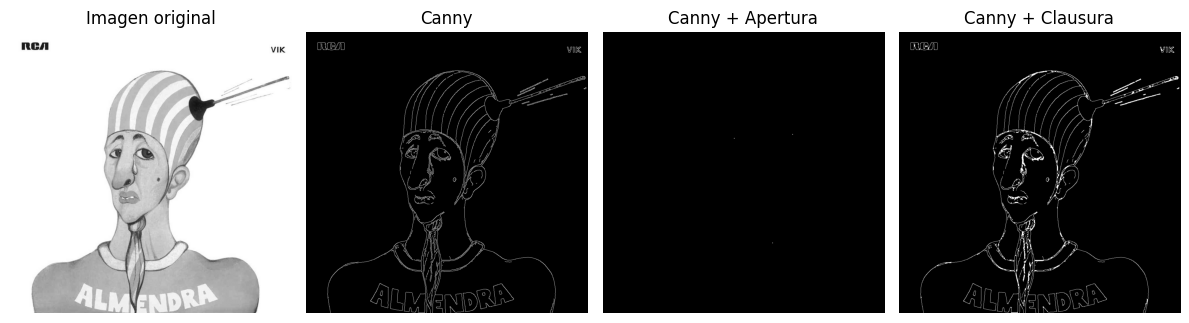

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagen = cv2.imread("./imagenes/almendra.jpg", cv2.IMREAD_GRAYSCALE)

# 1. Detección de bordes con Canny
bordes = cv2.Canny(imagen, threshold1=150, threshold2=220)

# 2. Operación de cierre para unir bordes rotos
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Aplicar apertura sobre los bordes detectados con Canny
bordes_apertura = cv2.morphologyEx(bordes, cv2.MORPH_OPEN, kernel)

# Aplicar clausura sobre los bordes detectados con Canny
bordes_clausura = cv2.morphologyEx(bordes, cv2.MORPH_CLOSE, kernel)

# Mostrar resultados
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
imagenes = [imagen, bordes, bordes_apertura, bordes_clausura]
titulos = ['Imagen original', "Canny", 'Canny + Apertura', 'Canny + Clausura']

for i in range(4):
    axs[i].imshow(imagenes[i], cmap='gray')
    axs[i].set_title(titulos[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

A partir de los resultados obtenidos, se puede concluir que la aplicación de operaciones morfológicas sobre los bordes detectados por el algoritmo Canny tiene un impacto muy específico y limitado para esta imagen. Como se observa, la operación de apertura resulta contraproducente, ya que su primer paso de erosión elimina por completo los bordes, que son estructuras de apenas un píxel de grosor, dejando una imagen prácticamente en negro. Por otro lado, la operación de clausura sí logra su objetivo técnico de engrosar ligeramente los bordes y conectar algunos de los segmentos que estaban separados.

## Ejercicio 8

> Segmentación basada en regiones (crecimiento o split-merge) ¿Como se puede segmentar unaimagen expandiendo regiones homogéneas? Práctica sugerida: Usar skimage.segmentation.flood() o flood fill() para realizar crecimiento de regiones desde semillas.

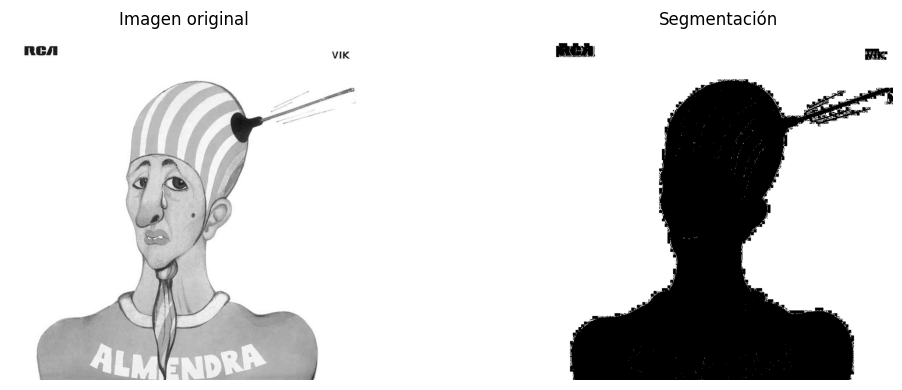

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill

# Cargar la imagen en escala de grises
imagen = cv2.imread("./imagenes/almendra.jpg", cv2.IMREAD_GRAYSCALE)

# Definir el punto de inicio (semilla) 
seed_point = (100, 100)

# Aplicar flood_fill
# La imagen se modifica in-place, por lo que creamos una copia
imagen_rellena = imagen.copy()
mascara_relleno = flood_fill(imagen_rellena, seed_point, new_value=255, tolerance=50)

# Crear una máscara binaria a partir de la nueva imagen
mascara_segmentacion = np.zeros_like(imagen)
mascara_segmentacion[imagen_rellena == 255] = 255


# Mostrar resultados
fig, axs = plt.subplots(1,2, figsize=(12, 4))
imagenes = [imagen, mascara_segmentacion]
titulos = ['Imagen original', 'Segmentación']

for i in range(2):
    axs[i].imshow(imagenes[i], cmap='gray')
    axs[i].set_title(titulos[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

La segmentación lograda puede considerarse parcialmente exitosa, ya que consigue aislar la silueta principal del personaje del fondo blanco. Sin embargo, la calidad de la segmentación es bastante gruesa y presenta defectos notables. Los bordes de la silueta son irregulares y pixelados, fallando en capturar los contornos suaves del dibujo original. Finalmente, las estructuras más finas y complejas, como la sopapa que se encuentra en la cabeza, no fueron segmentadas correctamente, apareciendo rotas e incompletas. Si bien el método logró una separación básica entre figura y fondo, no fue adecuado para una segmentación precisa que preserve los detalles y la fidelidad de los bordes.

## Ejercicio 10

> Segmentación por combinación de técnicas (pipeline) Pregunta: ¿Qué beneficios tiene combinar varias técnicas de segmentación en un mismo flujo de procesamiento? Práctica sugerida: Aplicar primero Canny + morfología para generar una máscara, luego segmentar con Watershed o K-means sobre la región recortada.

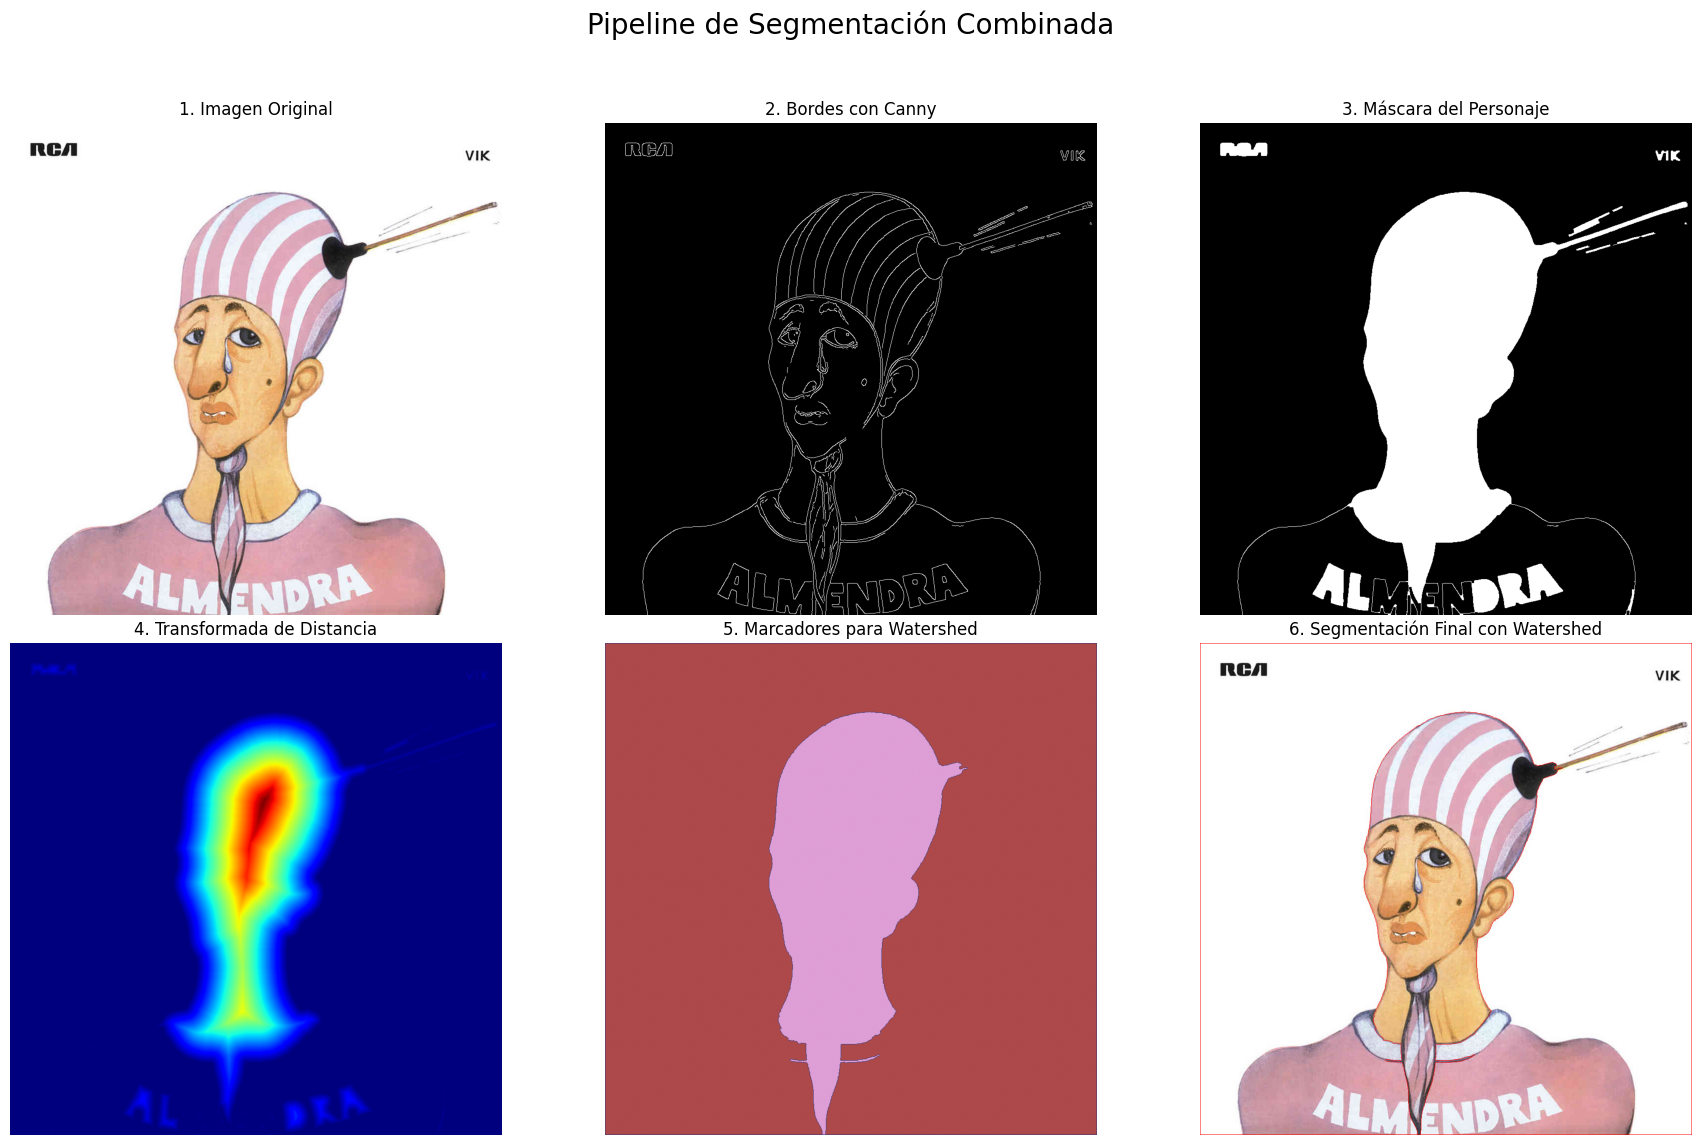

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagen_color = cv2.cvtColor(cv2.imread("./imagenes/almendra.jpg"), cv2.COLOR_BGR2RGB)
imagen_gris = cv2.cvtColor(imagen_color, cv2.COLOR_RGB2GRAY)
# --- PASO 1: Generar la Máscara Principal con Canny y Morfología ---

# Suavizar para reducir el ruido y mejorar la detección de bordes
imagen_suavizada = cv2.GaussianBlur(imagen_gris, (5, 5), 0)

# 1. Detección de bordes con Canny
bordes = cv2.Canny(imagen_suavizada, 110, 150)

# 2. Operación morfológica de Cierre para conectar bordes discontinuos
kernel = np.ones((5,5),np.uint8)
bordes_cerrados = cv2.morphologyEx(bordes, cv2.MORPH_CLOSE, kernel)

# 3. Encontrar los contornos y rellenarlos para crear una máscara sólida
contornos, _ = cv2.findContours(bordes_cerrados, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mascara = np.zeros_like(imagen_gris)
cv2.drawContours(mascara, contornos, -1, (255), thickness=cv2.FILLED)


# --- PASO 2: Aplicar Watershed para la Segmentación Final ---

# Fondo seguro: Dilatamos la máscara para estar seguros de qué es fondo.
fondo_seguro = cv2.dilate(mascara, kernel, iterations=3)

# Primer plano seguro: Usamos "distanceTransform" para encontrar los centros de los objetos
# dentro de la máscara y crear marcadores que no se toquen entre sí.
dist_transform = cv2.distanceTransform(mascara, cv2.DIST_L2, 5)
_, primer_plano_seguro = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
primer_plano_seguro = np.uint8(primer_plano_seguro)

# Región desconocida (donde el algoritmo trabajará)
region_desconocida = cv2.subtract(fondo_seguro, primer_plano_seguro)

# Crear los marcadores para Watershed
_, markers = cv2.connectedComponents(primer_plano_seguro)
# Sumamos 1 para que el fondo seguro (que es 0) no sea considerado "desconocido"
markers = markers + 1
# Marcamos la región desconocida con 0
markers[region_desconocida == 255] = 0

# Aplicar Watershed
markers = cv2.watershed(imagen_color, markers)

# Colorear el resultado para visualización
imagen_segmentada_watershed = imagen_color.copy()
imagen_segmentada_watershed[markers == -1] = [255, 0, 0] # Los bordes se marcan en rojo


# --- Visualización de todos los resultados juntos ---

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Pipeline de Segmentación Combinada', fontsize=20)

# Fila 1: Proceso de creación de la máscara
axs[0, 0].imshow(imagen_color)
axs[0, 0].set_title("1. Imagen Original")
axs[0, 0].axis('off')

axs[0, 1].imshow(bordes, cmap='gray')
axs[0, 1].set_title("2. Bordes con Canny")
axs[0, 1].axis('off')

axs[0, 2].imshow(mascara, cmap='gray')
axs[0, 2].set_title("3. Máscara del Personaje")
axs[0, 2].axis('off')

# Fila 2: Proceso de Watershed
axs[1, 0].imshow(dist_transform, cmap='jet')
axs[1, 0].set_title("4. Transformada de Distancia")
axs[1, 0].axis('off')

axs[1, 1].imshow(markers, cmap='tab20b')
axs[1, 1].set_title("5. Marcadores para Watershed")
axs[1, 1].axis('off')

axs[1, 2].imshow(imagen_segmentada_watershed)
axs[1, 2].set_title("6. Segmentación Final con Watershed")
axs[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

El pipeline de segmentación se ejecutó en dos fases principales. 

- Aislamiento del Objeto: Primero, se utilizó el detector de bordes Canny sobre la imagen original para trazar los contornos del personaje (Panel 2). A continuación, mediante operaciones morfológicas, estos bordes se conectaron y rellenaron para generar una máscara binaria limpia que aísla perfectamente la silueta completa del fondo (Panel 3).

- Preparación para Watershed: Esta máscara sirvió de base para aplicar la transformada de distancia (Panel 4), un método para identificar los puntos más alejados de los bordes, que se visualizan como las zonas más "cálidas" (rojo/amarillo). A partir de esta información, se generaron los marcadores (Panel 5), que actúan como "semillas" para el algoritmo final.

El pipeline fue muy exitoso en su objetivo de extraer la figura completa del personaje del fondo, como se aprecia en el resultado final (Panel 6), que es una imagen limpia y perfectamente recortada.

Sin embargo, el método, con los parámetros actuales, no logró el objetivo más avanzado de segmentar los componentes internos de la figura (como separar el rostro, el gorro y la camisa). El algoritmo de Watershed trató a todo el personaje como una única región y no encontró límites para trazar divisiones internas. Esto indica que el proceso es excelente para la extracción de objetos, pero necesitaría un ajuste más fino en la generación de marcadores para poder diferenciar y separar las distintas partes que componen la figura.

### Ejercicio 11

>Elegir y describir alguno de las siguientes tecnicas de segmentación: (a) Basada en Clustering, **(b) Basada en Grafos**, (c) Basadas en Modelos Probabilísticos y Estadísticas

La segmentación basada en grafos es una técnica que representa la imagen como un grafo, donde cada píxel o región de píxeles se considera un nodo, y las aristas que los conectan tienen un peso que indica la similitud (o diferencia) entre ellos. El objetivo principal es dividir o cortar este grafo en subgrafos, que corresponden a los objetos segmentados en la imagen. Para ello, se busca realizar cortes de manera que las aristas que conectan nodos dentro de un mismo subgrafo tengan pesos que indiquen una alta similitud (por ejemplo, bajo costo), mientras que las aristas que conectan diferentes subgrafos tengan pesos que reflejen una baja similitud (alto costo), logrando así una separación óptima de los objetos.

El proceso define una medida de qué tan buenos son los límites entre las regiones segmentadas y busca la partición que optimice esta medida en toda la imagen. Un algoritmo popular, como el de Felzenszwalb y Huttenlocher, recorre las aristas ordenadas por peso y decide si unir las regiones que conectan basándose en qué tan similares son las componentes internas en comparación con la diferencia entre ellas. Esto permite que la técnica se adapte a las características locales de la imagen, agrupando eficazmente los píxeles en regiones perceptualmente significativas que se corresponden con los objetos reales, sin necesidad de definir previamente cuántos segmentos se desean encontrar.